In [2]:
#2022-01-27 14:05:37 
%matplotlib inline
import os
import pandas as pd 
import numpy as np
import scipy as sp
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

from matplotlib import font_manager
# Add every font at the specified location
font_dir = ['/home/UTHSCSA/hef/Tools/miniconda3/fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
# Set font family globally
mpl.rcParams['font.family'] = 'Arial'


import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages

from datetime import datetime
time = datetime.now().strftime("%Y_%m_%d")


In [3]:
## add cancer info
cancer = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/master_table.v5.txt')
cancer = cancer[['ID','Final Diagnosis (Laura)','Disease Code level 2', 'Disease Code level 1', 'Tumor Collected (Primary or Met)','Gender','Age(year)','Therapy prior to PDX collection']]
def add_cancer_info(data, column):
    k = []
    for ids in list(data[column]):
        if str(ids) in list(cancer['ID']):
            
            k.append(list(cancer[cancer['ID'] == str(ids)].iloc[0]))
            #print( list(cancer[cancer['ID'] == str(ids)].iloc[0]))
        else:
            #print(str(ids))
            k.append(['NA'] * 8)
    data[['PDXID','Tumor Class','Tumor group','Tumor group2', 'Primary or Met','Gender','Age(year)','Therapy prior to PDX collection'] ]= pd.DataFrame(k)
    #print(pd.DataFrame(k))
    return data

In [4]:
## add time info
cancer2 = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/master_table.v5.txt')
cancer2 = cancer2[['ID','Engraftment time (P0-P1)']].fillna('NA')
def add_time_info(data, column):
    k = []
    for ids in list(data[column]):
        if str(ids) in list(cancer2['ID']):
            
            k.append(list(cancer2[cancer2['ID'] == str(ids)].iloc[0]))
        else:
            k.append(['NA'] * 3)
    data[['PDXID','Engraftment time'] ]= pd.DataFrame(k)
    #print(pd.DataFrame(k))
    return data

In [5]:
a,b,c,d,e,f,g,h,i = [plt.cm.winter, plt.cm.cool, plt.cm.spring, plt.cm.copper, plt.cm.bone, plt.cm.gist_heat, plt.cm.pink, plt.cm.summer, plt.cm.autumn]

cancer_ranking_all = [ 'Osteosarcoma', 'Clear Cell Sarcoma', 'Other Sarcoma',   'Wilms Tumor', 'Hepatoblastoma','Germ Cell Tumor',   'Neuroblastoma', 'Other Tumor']
color_ranking_all = ['brg', 'Oranges', 'Reds', 'Greens_r', 'Purples_r', 'Blues_r',  'nipy_spectral', 'Greys_r']

color_ranking_palette = [ f(.6), f(.8), f(.3), h(.6), b(.6), a(.6), h(.2), e(.6)]
color_ranking_dict = {'Osteosarcoma':  f(.6),  'Clear Cell Sarcoma':f(.8), 'Other Sarcoma':f(.3),  'Wilms Tumor': h(.6), 'Hepatoblastoma':b(.6),
                     'Germ Cell Tumor': a(.6),   'Neuroblastoma':h(.2), 'Other Tumor': e(.6)}


cancer_ranking_all2 = [ 'Ovarian tumor', 'Wilms Tumor', 'Ewing Sarcoma', 'Mesothelioma', 'Clear Cell Sarcoma', 'Hepatoblastoma', 'Neuroblastoma',
                        'Germ Cell Tumor', 'Pleomorphic Sarcoma', 'Adrenal cortical carcinoma', 'Osteosarcoma', 'ERMS', 'Glioblastoma']
color_ranking_palette2 = ['darkred',h(.6), 'red', 'gold', f(.3), b(.6), h(.2),a(.6), 'firebrick', 'hotpink', f(.6), f(.7), 'darkviolet']


In [6]:
estimate = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/1.exp_matrix/immune_score/PDX_estimate_score.gct' , comment = '#', index_col=0)
estimate = estimate.drop('Description', axis = 1).T
estimate.index = estimate.index.str.replace('^X', '', regex = True)
estimate.index = estimate.index.str.replace('.', '-', regex = True) 

exp = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/1.exp_matrix/exp.kallisto.tpm.protein_coding.txt', sep = '\t')
exp = exp.set_index(['gene_name', 'ensemble_id'])
exp = exp[[i for i in exp.columns if( not i.startswith('SARC')) & ('1947' not in i) & ('1837' not in i) & ('1853' not in i)]]

ids = [i for i in exp.columns if i in list(estimate.index)]
estimate = estimate.T[ids]

remove_immune_gene = []
for i in range(len(exp)):
    line = list(exp.iloc[i])
    r,p = sp.stats.pearsonr(line, list(estimate.loc['ImmuneScore']))
    if (p >= 0.05) | (r <= 0):
        remove_immune_gene.append(i)
exp_new = exp.reset_index().T[remove_immune_gene].T.set_index(['gene_name', 'ensemble_id']).astype(float)

/home/UTHSCSA/hef/Tools/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [7]:
data_new = exp_new
data_new = data_new.drop(data_new.T.filter(regex='MT-').columns, axis = 0)  #remove MT genes
data_new = data_new.drop(data_new.T.filter(regex='RPS').columns, axis = 0)  #remove RPS genes
data_new = data_new.drop(data_new.T.filter(regex='RPL').columns, axis = 0)  #remove RPL genes

### correlation

In [8]:
data = data_new
data.columns = data.columns.str.replace('875194', '1939-Dup', regex = True)

In [9]:
k = list(data.columns.str.split('[-_]').str[0])

paired_id = list(set([i for i in k if k.count(i) > 1]))
#paired_id.remove('1853')
paired_sample = sorted([col for col in data.columns for i in paired_id if i in col ])

add = pd.DataFrame(paired_sample)
add['PatientID'] = add[0].str.split('_').str[0]
add = add_cancer_info(add, 'PatientID')
add = add.replace('Clear Cell Sarcoma', 'Sarcoma_1')
add = add.replace('Osteosarcoma', 'Sarcoma_2')
add = add.replace('Other Sarcoma', 'Sarcoma_3')


add = add.sort_values(['Tumor group2', 'Tumor Class', 'PDXID'])
paired_sample = list(add[0])
add 

,0,PatientID,PDXID,Tumor Class,Tumor group,Tumor group2,Primary or Met,Gender,Age(year),Therapy prior to PDX collection
6,1795_PDX_RNAseq,1795,1795,Mixed germ cell tumor,Germ Cell Tumor,Germ Cell Tumor,primary,Male,17.0,No treatment
7,1795_PT_RNAseq,1795,1795,Mixed germ cell tumor,Germ Cell Tumor,Germ Cell Tumor,primary,Male,17.0,No treatment
10,1826_PDX_RNAseq,1826,1826,Mixed germ cell tumor,Germ Cell Tumor,Germ Cell Tumor,primary,Male,14.0,No treatment
11,1826_PT_RNAseq,1826,1826,Mixed germ cell tumor,Germ Cell Tumor,Germ Cell Tumor,primary,Male,14.0,No treatment
0,1739_PDX_RNAseq,1739,1739,Hepatoblastoma,Hepatoblastoma,Hepatoblastoma,primary,Male,2.0,no treatment
1,1739_PT_RNAseq,1739,1739,Hepatoblastoma,Hepatoblastoma,Hepatoblastoma,primary,Male,2.0,no treatment
20,1957_PDX_RNAseq,1957,1957,Hepatoblastoma,Hepatoblastoma,Hepatoblastoma,primary,Male,1.0,Chemotherapy
21,1957_PT_RNAseq,1957,1957,Hepatoblastoma,Hepatoblastoma,Hepatoblastoma,primary,Male,1.0,Chemotherapy
26,498_PDX_RNAseq,498,498,Hepatoblastoma,Hepatoblastoma,Hepatoblastoma,primary,Female,1.0,No treatment
27,498_PT_RNAseq,498,498,Hepatoblastoma,Hepatoblastoma,Hepatoblastoma,primary,Female,1.0,No treatment


In [11]:
df = data[paired_sample]
cor, p = sp.stats.spearmanr(df)
df = pd.DataFrame(cor, columns=paired_sample, index = paired_sample)

df = df.filter(regex = 'PDX', axis = 0)

cols = [i for i in df.columns if ('PT' in i )|('1939' in i)|('560' in i)]
cols.remove('560_PDX_RNAseq')
df = df[cols]

In [12]:
df.columns = labels= list(df.columns.str.replace('_RNAseq','', regex = True))
df.index = labels= list(df.index.str.replace('_RNAseq','', regex = True))


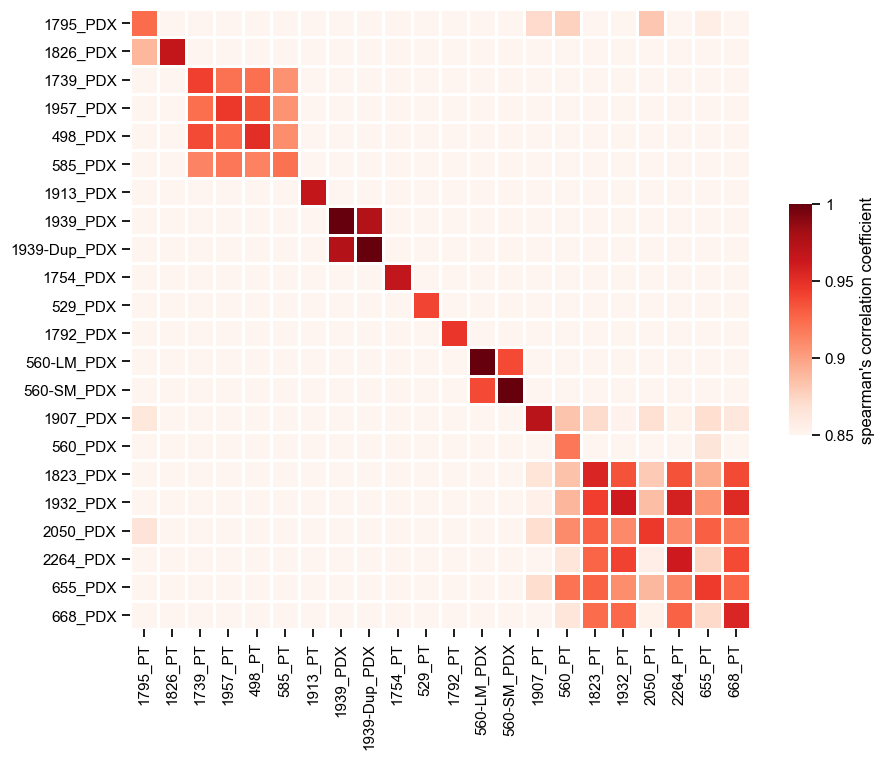

In [13]:
sns.set_context('notebook', font_scale = 1, rc = {'lines.linewidth':0}) 
fig = plt.figure(figsize=(10,10))

g = sns.heatmap(df, cmap = 'Reds', 
                vmin = 0.85, vmax = 1, square=True,
           cbar_kws={"shrink": .3, "aspect":10, 'label': "spearman's correlation coefficient"}, linewidths=1, linecolor='white')

colorbar = g.collections[0].colorbar
colorbar.set_ticks([ 0.85, 0.9,0.95,1])
colorbar.set_ticklabels([ '0.85', '0.9','0.95','1']) 

#plt.savefig(outdir + '/PDX_PT.exp_new.correlation.heatmap.'+time+'.pdf', format='pdf', dpi = 600,  bbox_inches='tight')

In [15]:
pd.DataFrame(np.diag(df), index = df.columns).sort_values(0)

,0
560_PT,0.919127
585_PT,0.921115
1795_PT,0.924125
529_PT,0.940146
1739_PT,0.942421
655_PT,0.943768
1957_PT,0.944950
2050_PT,0.945504
1792_PT,0.946672
498_PT,0.950562


In [16]:
df 

,1795_PT,1826_PT,1739_PT,1957_PT,498_PT,585_PT,1913_PT,1939_PDX,1939-Dup_PDX,1754_PT,...,560-LM_PDX,560-SM_PDX,1907_PT,560_PT,1823_PT,1932_PT,2050_PT,2264_PT,655_PT,668_PT
1795_PDX,0.924125,0.837070,0.835311,0.798714,0.793768,0.788756,0.772164,0.785364,0.782565,0.800469,...,0.810195,0.808391,0.871470,0.875836,0.846171,0.832012,0.881910,0.838307,0.856978,0.849324
1826_PDX,0.889327,0.966384,0.757084,0.763246,0.750316,0.735578,0.720566,0.768205,0.768251,0.741480,...,0.747604,0.739811,0.783349,0.779245,0.800845,0.806077,0.796586,0.796761,0.784750,0.797244
1739_PDX,0.775395,0.748217,0.942421,0.920902,0.922361,0.906402,0.697643,0.775491,0.775114,0.719634,...,0.730488,0.726667,0.756705,0.767309,0.768560,0.793168,0.776315,0.773527,0.766009,0.777386
1957_PDX,0.815818,0.787283,0.923085,0.944950,0.934411,0.905378,0.714445,0.791770,0.787861,0.737720,...,0.743749,0.743190,0.786135,0.801048,0.806511,0.822593,0.813670,0.808568,0.797025,0.818540
498_PDX,0.788398,0.753109,0.937555,0.924992,0.950562,0.908818,0.698298,0.783454,0.781269,0.735038,...,0.744885,0.741876,0.779302,0.783645,0.780478,0.792467,0.783921,0.778099,0.768030,0.790741
585_PDX,0.784050,0.755605,0.912962,0.918556,0.913411,0.921115,0.681137,0.788765,0.787833,0.717081,...,0.745069,0.742527,0.769108,0.768615,0.774785,0.789823,0.776670,0.778647,0.760586,0.781782
1913_PDX,0.764393,0.744328,0.733645,0.705491,0.700804,0.702400,0.966789,0.758530,0.753442,0.777549,...,0.739981,0.740702,0.796511,0.800917,0.809905,0.795699,0.789740,0.801156,0.793938,0.814564
1939_PDX,0.785321,0.770601,0.786060,0.765712,0.761099,0.763460,0.741883,1.000000,0.974284,0.788082,...,0.799778,0.798175,0.812836,0.807084,0.809640,0.806883,0.794881,0.811798,0.785460,0.818649
1939-Dup_PDX,0.784010,0.767313,0.782419,0.762798,0.761149,0.762173,0.739901,0.974284,1.000000,0.778213,...,0.796913,0.794132,0.807379,0.803368,0.805358,0.807706,0.792595,0.813112,0.785328,0.816273
1754_PDX,0.771935,0.738146,0.738614,0.696621,0.699081,0.689118,0.741431,0.774527,0.764230,0.967753,...,0.765859,0.770385,0.814567,0.820189,0.801493,0.786228,0.794836,0.788729,0.798498,0.804573


### umap & tsne

In [12]:
dt = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/3.plot/3.exp/TNSE_UMAP.top1500.txt', sep = '\t',index_col=0)
dt

,index,TSNE1,TSNE2,UMAP1,UMAP2,PatientID,Datatype,PDXID,Tumor Class,Tumor group,Tumor group2,Primary or Met,Gender,Age(year),Therapy prior to PDX collection
0,1957_PDX_RNAseq,-4.199373,1.273044,4.643697,2.326205,1957,PDX,1957,Hepatoblastoma,Hepatoblastoma,Hepatoblastoma,primary,Male,1.0,Chemotherapy
1,561_PDX_RNAseq,-0.614610,0.596476,14.218989,6.958488,561,PDX,561,Wilms Tumor,Wilms Tumor,Wilms Tumor,primary/recurrent,Male,16.0,Yes (unspecified)
2,1792_PDX_RNAseq,0.402092,1.634975,18.119547,3.657415,1792,PDX,1792,Osteosarcoma,Sarcomas,Osteosarcoma,primary,Female,17.0,Chemotherapy
3,1907_PT_RNAseq,-0.681636,0.896030,14.140224,6.281932,1907,PT,1907,Pleomorphic Sarcoma,Sarcomas,Other Sarcoma,primary,Female,5.0,Chemotherapy
4,1917_PDX_RNAseq,-2.331075,1.371798,14.409525,5.013672,1917,PDX,1917,Mixed germ cell tumor,Germ Cell Tumor,Germ Cell Tumor,primary,Male,17.0,No treatment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1795_PT_RNAseq,-1.916896,1.436922,14.252248,5.428530,1795,PT,1795,Germ Cell tumor,Germ Cell Tumor,Germ Cell Tumor,primary,Male,17.0,No treatment
76,1826_PT_RNAseq,-2.357719,1.520567,14.540175,5.114143,1826,PT,1826,Germ Cell tumor,Germ Cell Tumor,Germ Cell Tumor,primary,Male,14.0,No treatment
77,530_PDX_RNAseq,0.260383,-0.995719,15.151171,8.373577,530,PDX,530,Neuroblastoma,Neuroblastoma,Neuroblastoma,primary,Male,2.0,No treatment
78,1939-Dup_PDX_RNAseq,-2.773234,-0.246290,14.928749,7.342932,1939-Dup,PDX,1939-Dup,Adrenal cortical carcinoma,Other tumors,Other Tumor,primary,Male,13.0,No treatment


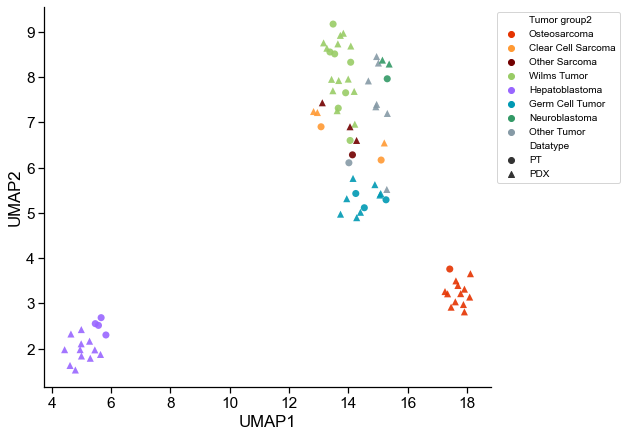

In [13]:
sns.set_context('notebook', font_scale = 1.4, rc = {'lines.linewidth':1}) 
fig = plt.figure(figsize=(8,7))

g= sns.scatterplot(data = dt, x = 'UMAP1', y= 'UMAP2', 
                hue = 'Tumor group2', hue_order=  color_ranking_dict.keys(), palette= color_ranking_dict.values(),
                style='Datatype', style_order=['PT','PDX'], markers=[ 'o', '^'], 
                linewidth = 0, s=50, alpha=0.9
               )
g.legend(loc = 1, bbox_to_anchor=(1.3, 1), fontsize=10)
sns.despine()